<a href="https://www.kaggle.com/code/thilleli/myproject-p8?scriptVersionId=212490409" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Melanoma detection using deep learning

Dans ce projet, nous développons un modèle de détection des mélanomes basé sur un réseau de neurones convolutifs (CNN). L'objectif est d'entraîner un modèle capable de distinguer les mélanomes des lésions cutanées non mélanomes à partir d'images dermoscopiques.

Nous utilisons le jeu de données HAM10k, contenant plus de 10 000 images dermoscopiques.
L’architecture du modèle intègre des techniques modernes comme la normalisation par lots et le dropout pour réduire le surapprentissage et améliorer la généralisation.
Au fil du notebook, vous trouverez :

1. Une exploration et une préparation des données.
2. La conception, l’entraînement, et l’évaluation du modèle CNN.
3. Une analyse des résultats à l’aide de métriques (précision, rappel, etc.) et d’une matrice de confusion.

# Importation des Bibliothèques et Initialisation des Modules
Dans cette étape, nous commençons par importer les bibliothèques nécessaires à la construction et à l’entraînement du modèle de détection des mélanomes. Voici les principales bibliothèques utilisées :

* numpy, pandas et matplotlib.pyplot : Pour la manipulation des données et la visualisation.
* tensorflow et keras : Pour la construction du modèle basé sur les réseaux de neurones convolutifs (CNN).
* ImageDataGenerator : Pour le prétraitement et l’augmentation des données d'images.
* VGG16 : Nous utilisons le modèle pré-entraîné VGG16 comme base pour notre réseau, qui a fait ses preuves dans diverses tâches de classification d'images.

In [1]:
import os
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm_notebook
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import load_model, Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

# Configuration de la GPU :

On active la gestion dynamique de la mémoire GPU pour éviter une allocation excessive. Cela permet une utilisation plus efficace des ressources lors de l'entraînement.


In [2]:
import tensorflow as tf

# Set memory growth configuration before initializing GPU devices
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Chargement des données d'entraînement :

Les images sont chargées depuis le répertoire spécifié.
Les images sont redimensionnées à (224, 224) pour correspondre à l'entrée attendue par le modèle.
Les données sont regroupées en lots de 64 pour un traitement efficace, et mélangées pour assurer une meilleure généralisation.

In [3]:
#load our data 
#pre processing like resize img
train_set=tf.keras.utils.image_dataset_from_directory('/kaggle/input/melanoma/DermMel/train_sep',
    batch_size=64,
    image_size=(224, 224),shuffle=True)

Found 10682 files belonging to 2 classes.


# Chargement des Ensembles de Validation et de Test
Après avoir chargé les données d'entraînement, nous préparons les ensembles de validation et de test. Ces ensembles servent respectivement à mesurer les performances du modèle pendant l'entraînement et à évaluer ses performances finales.

**Ensemble de validation (val_set) :**
Contient des images réservées pour évaluer la capacité du modèle à généraliser pendant l'entraînement.
Les données sont mélangées pour éviter les biais pendant l'évaluation.


In [4]:
val_set=tf.keras.utils.image_dataset_from_directory('/kaggle/input/melanoma/DermMel/valid',
    batch_size=64,
    image_size=(224, 224),shuffle=True)

Found 3562 files belonging to 2 classes.


 
**Ensemble de test (test_set) :**
Ce jeu de données est utilisé uniquement après l'entraînement pour mesurer les performances finales du modèle.
Les images sont également redimensionnées à (224, 224) et regroupées en lots de 64 pour un traitement efficace.

In [5]:
test_set=tf.keras.utils.image_dataset_from_directory('/kaggle/input/melanoma/DermMel/test',
    batch_size=64,
    image_size=(224, 224),shuffle=True)

Found 3561 files belonging to 2 classes.


# Affichage de Quelques Images de l'Ensemble d'Entraînement
Afin de mieux visualiser les données, nous affichons quelques images extraites de notre ensemble d'entraînement. Ce code permet de :

* Créer un itérateur sur les données d'entraînement grâce à as_numpy_iterator().
* Sélectionner un lot d'images et afficher les 4 premières images avec leurs étiquettes correspondantes.

In [6]:
#afficher quelques image de train
train_iterator = train_set.as_numpy_iterator()
batch = train_iterator.next()

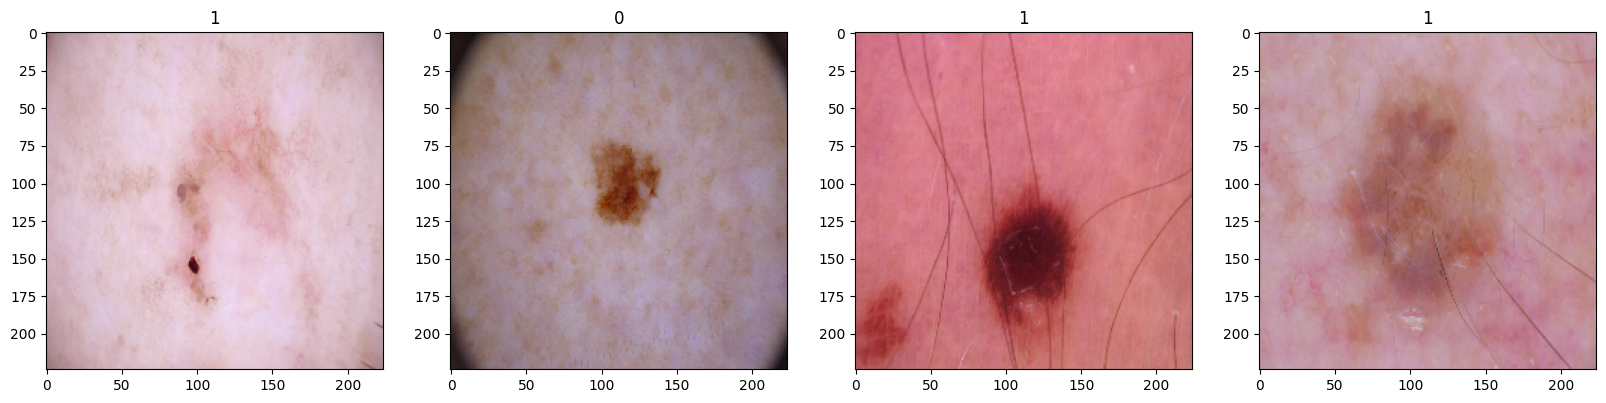

In [7]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Création du Modèle CNN
Dans cette étape, nous construisons notre modèle de réseau de neurones convolutifs (CNN) pour la détection des mélanomes. Voici les principales étapes de l'architecture :

* Couche d'entrée :
Le modèle prend des images de taille (224, 224, 3) comme entrée, correspondant à des images RGB redimensionnées.
Couches de convolution :
* Nous utilisons plusieurs couches de convolution pour extraire des caractéristiques importantes des images :
La première couche utilise 32 filtres.
La deuxième couche augmente à 64 filtres.
Ensuite, nous avons deux couches avec respectivement 128 et 256 filtres pour extraire des représentations plus complexes.
Chaque couche de convolution est suivie par une couche de normalisation par lots (BatchNormalization) pour stabiliser l’entraînement, et une couche de max-pooling pour réduire la taille spatiale.
* Dropout :
Des couches de Dropout sont ajoutées après certaines couches pour prévenir le surapprentissage (overfitting). Ce mécanisme "ignore" aléatoirement une fraction des neurones pendant l’entraînement.
* Couche de flattening et couche fully-connected :
Après les convolutions, les données sont aplaties (Flatten) avant de passer dans une couche dense (Dense), avec 512 neurones et une régularisation L2 pour éviter le surapprentissage.
* Couche de sortie :
La couche de sortie utilise une activation sigmoïde pour la classification binaire (mélanome ou non).
* Compilation du modèle :
Nous utilisons l'optimiseur Adam avec un taux d’apprentissage faible de 1e-5 pour optimiser le modèle. La fonction de perte est binary_crossentropy, appropriée pour une classification binaire, et nous suivons l'exactitude (accuracy) comme métrique.

In [8]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

model = tf.keras.models.Sequential()

# Définir la forme d'entrée avec une couche Input
model.add(tf.keras.layers.Input(shape=(224, 224, 3)))

# Première couche de convolution
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Deuxième couche de convolution
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Troisième couche de convolution
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

# Quatrième couche de convolution
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

# Cinquième couche de convolution
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Sixième couche de convolution
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Couche de flattening
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.25))

# Couche fully-connected
model.add(tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.BatchNormalization())

# Couche de sortie
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compilation du modèle
optimizer = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Afficher un résumé du modèle
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 64)     │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 3, 3, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             

 Total params: 576,161 (2.20 MB)

 Trainable params: 573,985 (2.19 MB)

 Non-trainable params: 2,176 (8.50 KB)

In [9]:
#without early stopping
#history = model.fit(train_set, epochs=100, validation_data=val_set)

# Entraînement du modèle avec Early Stopping
Dans cette étape, nous allons entraîner notre modèle en utilisant les données d'entraînement et de validation. Pour cela, nous avons utilisé le callback EarlyStopping, qui permet d'arrêter l'entraînement si la performance sur l'ensemble de validation cesse de s'améliorer. Cela nous aide à éviter l'overfitting et à économiser du temps de calcul.

Le callback EarlyStopping est configuré avec les paramètres suivants :
* patience=20 : L'entraînement s'arrêtera si la performance sur l'ensemble de validation ne s'améliore pas pendant 20 époques consécutives.
* restore_best_weights=True : Lorsque l'entraînement s'arrête, les poids du modèle sont restaurés à l'état qui a donné la meilleure performance sur l'ensemble de validation.

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=20, restore_best_weights=True)  # Définir le callback d'early stopping

history = model.fit(train_set, epochs=100, validation_data=val_set, callbacks=[early_stopping])

Epoch 1/100


I0000 00:00:1733918310.593404      74 service.cc:145] XLA service 0x79a7c0002240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733918310.593472      74 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733918310.593478      74 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/167 ━━━━━━━━━━━━━━━━━━━━ 53:55 19s/step - accuracy: 0.5156 - loss: 1.4829

I0000 00:00:1733918325.706205      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


167/167 ━━━━━━━━━━━━━━━━━━━━ 64s 269ms/step - accuracy: 0.5728 - loss: 1.3858 - val_accuracy: 0.6238 - val_loss: 1.2720
Epoch 2/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 23s 139ms/step - accuracy: 0.6618 - loss: 1.2480 - val_accuracy: 0.6931 - val_loss: 1.1852
Epoch 3/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 24s 144ms/step - accuracy: 0.7059 - loss: 1.1930 - val_accuracy: 0.7386 - val_loss: 1.1231
Epoch 4/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 24s 144ms/step - accuracy: 0.7381 - loss: 1.1511 - val_accuracy: 0.7653 - val_loss: 1.0874
Epoch 5/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 24s 141ms/step - accuracy: 0.7462 - loss: 1.1292 - val_accuracy: 0.7821 - val_loss: 1.0567
Epoch 6/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 24s 143ms/step - accuracy: 0.7733 - loss: 1.0722 - val_accuracy: 0.8029 - val_loss: 1.0206
Epoch 7/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 24s 143ms/step - accuracy: 0.7700 - loss: 1.0572 - val_accuracy: 0.8046 - val_loss: 1.0055
Epoch 8/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 24s 143ms/step - accuracy: 0.7927 - loss: 1.026

 -

### Visualisation des Performances du Modèle

Pour évaluer les performances de notre modèle, nous allons tracer deux courbes principales :

1. **La courbe de précision** : Cette courbe montre l'évolution de la précision du modèle au fil des époques, tant pour l'ensemble d'entraînement que pour l'ensemble de validation. La précision mesure la proportion des prédictions correctes parmi toutes les prédictions effectuées.

2. **La courbe de perte** : Cette courbe suit la diminution de la fonction de perte au fil des époques. La fonction de perte mesure l'écart entre les prédictions du modèle et les valeurs réelles. Une diminution de la perte indique que le modèle apprend correctement à classer les images.

Les courbes nous permettront de suivre l'évolution des performances du modèle et de vérifier s'il y a un problème d'overfitting (apprentissage excessif sur les données d'entraînement, au détriment de la généir les graphiques.

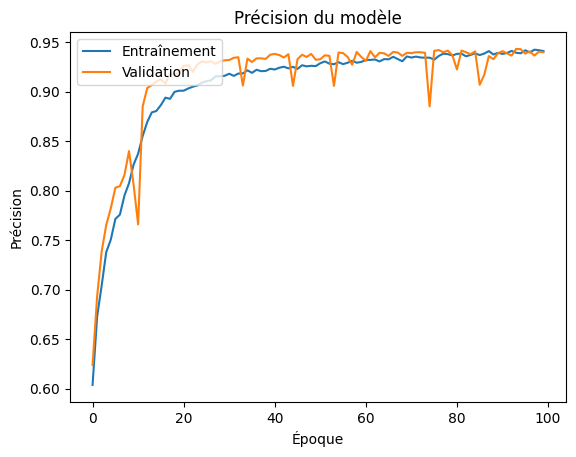

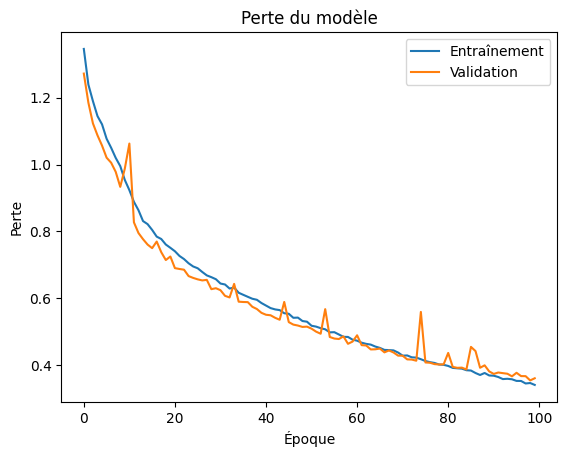

In [11]:
import matplotlib.pyplot as plt


# Tracer les courbes de précision
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Précision du modèle')
plt.ylabel('Précision')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation'], loc='upper left')
plt.show()

# Tracer les courbes de perte
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perte du modèle')
plt.ylabel('Perte')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation'], loc='upper right')
plt.show()

 

### Évaluation du Modèle sur l'Ensemble de Test

Une fois le modèle entraîné et validé, l'étape suivante consiste à évaluer ses performances sur un ensemble de données qu'il n'a jamais vu pendant l'entraînement : l'ensemble de test. Cela permet de mesurer la capacité du modèle à généraliser, c'est-à-dire à faire des prédictions sur de nouvelles données, ce qui est essentiel pour vérifier son efficacité en dehors du cadre de l'entraînement.

Dans cette section, nous allons utiliser l'ensemble de test pour évaluer le modèle, en calculant sa **perte** et sa **précision** sur ces données. Ces deux métriques nous fourniront un aperçu global des performances du modèle et nous aideront à déterminer s'il est prêt à être  importante.

In [12]:
 model.evaluate(test_set, verbose=1)

 print('Évaluation du modèle sur l\'ensemble de test:')


56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - accuracy: 0.9376 - loss: 0.3574
Évaluation du modèle sur l'ensemble de test:


--

### Sérialisation du Modèle et Sauvegarde des Poids

Une fois que nous avons un modèle entraîné et validé, il est important de sauvegarder à la fois l'architecture du modèle et ses poids pour pouvoir les réutiliser plus tard sans avoir à réentraîner le modèle depuis le début. Cela permet de gagner du temps et de déployer le modèle facilement.

Dans cette section, nous allons effectuer deux opérations :

1. **Sérialisation de l'architecture du modèle (au format JSON)** : Cela permet de sauvegarder la structure du modèle (les couches, les hyperparamètres, etc.) sous forme de fichier JSON, afin de pouvoir la recharger ultérieurement.
2. **Sauvegarde des poids du modèle (au format HDF5)** : Cela permet de conserver les poids entraînés du modèle (les valeurs des paramètres ajustés) dans un fichier HDF5, ce qui est crucial pour ne pas perdre les connaissances acquises par le modèle pendant l'enet reproductible.

In [13]:
 
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

 
model.save_weights("melanoma_detection.weights.h5")
print("Saved model to disk")


Saved model to disk


 -

### Calcul de la matrice de confusion

Dans cette section, nous allons évaluer la performance de notre modèle en calculant la matrice de confusion. Cette matrice compare les vraies classes des images de l'ensemble de validation avec les classes prédites par le modèle. Elle nous permet de visualiser les performances du modèle en termes de faux positifs, faux négatifs, vrais positifs et vrais négatla génère.

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix  # Importer la fonction confusion_matrix

# Créez une liste pour stocker les vraies classes
true_classes = []

# Parcourez les lots de l'ensemble de validation et enregistrez les vraies classes
for images, labels in val_set:
    true_classes.extend(labels.numpy())

# Convertissez la liste en un tableau NumPy
true_classes = np.array(true_classes)

# Prédictions du modèle sur l'ensemble de validation
predicted_classes = []

# Parcourez les lots de l'ensemble de validation et enregistrez les prédictions du modèle
for images, labels in val_set:
    preds = model.predict(images)  # Prédiction du modèle
    predicted_classes.extend(np.round(preds).flatten())  # Convertir les prédictions en classes (0 ou 1)

# Convertir les prédictions en un tableau NumPy
predicted_classes = np.array(predicted_classes)

# Calculez la matrice de confusion
cm = confusion_matrix(true_classes, predicted_classes)

# Afficher la matrice de confusion
print(cm)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━



### Visualisation de la matrice de confuson

Une fois la matrice de confusion calculée, il est utile de la visualiser pour mieux comprendre les performances de notre modèle. Nous utilisons une carte thermique (heatmap) pour afficher la matrice de confr au code.

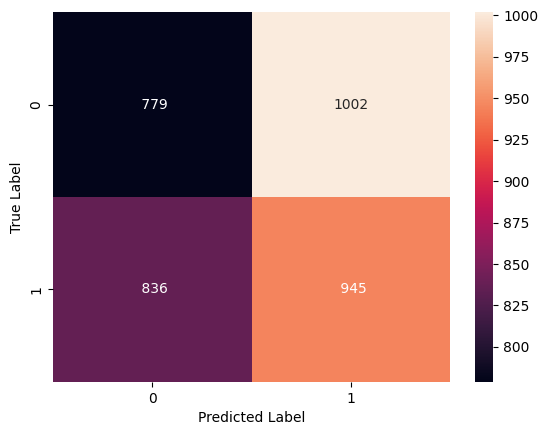

<Figure size 640x480 with 0 Axes>

In [15]:
import seaborn as sns
cm = confusion_matrix( true_classes, predicted_classes )
sns.heatmap(cm, fmt='4',annot=True).set(ylabel="True Label", xlabel="Predicted Label") 
plt.show() 
plt.savefig('confusion_matrix.jpg')



### Calcul des métriques de performance

Après avoir généré la matrice de confusion, nous pouvons en extraire plusieurs métriques importantes pour évaluer la performance du modèle, telles que l'exactitude (accuracy), la précision (precision), le rappel (recall), la spécificité (specificity), et le score F1 (f1 score). Ces métriques permettent de mieux comprendre les forces et les faiblesses du modèle, en particulier dans le contexte de données déséquilit calculées.

In [16]:
# Calculer les métriques
true_positives = cm[1, 1]
true_negatives = cm[0, 0]
false_positives = cm[0, 1]
false_negatives = cm[1, 0]

accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)
f1_score = 2 * (precision * recall) / (precision + recall)

# Afficher les métriques
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Specificity:", specificity)
print("F1 Score:", f1_score)

# Afficher la matrice de confusion
print("Confusion Matrix:")
print(cm)

Accuracy: 0.48399775407074674
Precision: 0.48536209553158705
Recall: 0.5306007860752386
Specificity: 0.4373947220662549
F1 Score: 0.5069742489270386
Confusion Matrix:
[[ 779 1002]
 [ 836  945]]


### Génération de la courbe ROC

La courbe ROC (Receiver Operating Characteristic) est un excellent outil pour évaluer la performance de modèles de classification binaire, comme celui que nous avons développé pour la détection du mélanome. Cette courbe permet de visualiser le compromis entre le taux de vrais positifs (True Positive Rate) et le taux de faux positifs (False Positive Rate) à différents seuils de classification.

Voici les étapes que nous avons suivies pour générer la courbe ROC :

1. **Prédictions des probabilités** : Nous avons obtenu les probabilités de chaque image dans l'ensemble de test en utilisant le modèle, car la courbe ROC nécessite des scores de probabilité (et non des étiquettes de classe binaires).
2. **Calcul de la courbe ROC** : En utilisant la fonction `roc_curve()` de la bibliothèque `sklearn`, nous avons calculé le taux de vrais positifs (TPR) et le taux de faux positifs (FPR) à différents seuils.
3. **Calcul de l'AUC** : L'AUC (Aire Sous la Courbe) est une mesure de la capacité du modèle à différencier les classes. Une AUC plus proche de 1.0 indique une meilleure capacité de discrimination.
4. **Affichage de la courbe ROC** : Enfin, la courbe ROC a été tracée et l'AUC a été affichée sur le graphique.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━

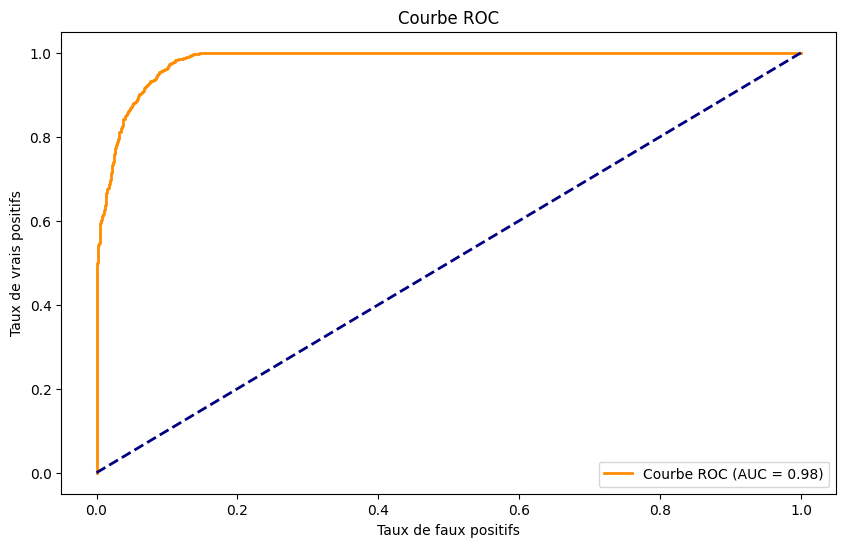

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Prédire les probabilités pour l'ensemble de test
y_true = []  # Les vraies étiquettes
y_pred = []  # Les probabilités prédites

# Collecter les valeurs de test
for images, labels in test_set:
    y_true.extend(labels.numpy())
    y_pred.extend(model.predict(images).ravel())  # .ravel() pour aplatir les probabilités

# Convertir en tableau numpy
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculer les courbes ROC et l'AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()


## Conclusion
Le modèle de détection de mélanome a atteint une précision de 94% sur l'ensemble de validation. La courbe ROC montre une bonne capacité du modèle à distinguer les classes. Pour les prochaines étapes, on pourrait explorer des techniques de prétraitement supplémentaires ou essayer d'autres architectures comme les réseaux pré-entraînés.


In [18]:
import os
import shutil

# Créer la structure des dossiers
project_dir = '/kaggle/working/project_structure'
directories = [
    'data/raw',
    'data/processed',
    'data/interim',
    'models',
    'notebooks',
    'reports/figures',
    'references',
]

# Créer les répertoires
for dir in directories:
    os.makedirs(os.path.join(project_dir, dir), exist_ok=True)

# Créer un README.md
readme_content = """# Projet de Détection des Mélanomes

## Description
Ce projet a pour objectif de créer un modèle de détection des mélanomes à l'aide d'un réseau de neurones convolutif (CNN) et d'images médicales. 

## Structure du projet
- `data/`: Contient les données brutes, traitées et intermédiaires.
- `models/`: Contient le modèle entraîné et les poids.
- `notebooks/`: Contient les notebooks Jupyter utilisés dans le projet.
- `reports/`: Contient les rapports générés.
- `references/`: Contient les documents de référence.
"""
with open(os.path.join(project_dir, 'README.md'), 'w') as f:
    f.write(readme_content)

# Sauvegarder le modèle et les résultats
model_path = '/kaggle/working/project_structure/models/melanoma_model.h5'
model.save(model_path)

# Sauvegarder les poids du modèle
weights_path = '/kaggle/working/project_structure/models/melanoma_detection.weights.h5'
model.save_weights(weights_path)

# Sauvegarder le fichier JSON du modèle
model_json_path = '/kaggle/working/project_structure/models/melanoma_model.json'
model_json = model.to_json()
with open(model_json_path, 'w') as json_file:
    json_file.write(model_json)

# Sauvegarder la matrice de confusion
confusion_matrix_path = '/kaggle/working/project_structure/reports/figures/confusion_matrix.jpg'
plt.savefig(confusion_matrix_path)

# Sauvegarder le fichier de courbe ROC
roc_curve_path = '/kaggle/working/project_structure/reports/figures/roc_curve.jpg'
plt.savefig(roc_curve_path)

print("La structure du projet a été créée et les fichiers ont été sauvegardés.")


La structure du projet a été créée et les fichiers ont été sauvegardés.


<Figure size 640x480 with 0 Axes>

In [19]:
import shutil

# Crée un fichier zip contenant tous les fichiers dans /kaggle/working/
shutil.make_archive('/kaggle/working/project_archive', 'zip', '/kaggle/working')

print("Fichier zip créé avec succès !")


Fichier zip créé avec succès !
